In [5]:
import pandas as pd
import numpy as np
import os, glob
import os.path, time
import zipfile as zp
import re
import random
from datetime import datetime, date
from datetime import datetime, timedelta
from scipy import optimize
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from scipy import stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.base.model import LikelihoodModel
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
import unicodedata

In [6]:
def subID_list():
    subID = ['797','806','809','826','843','845','855','856','857','1031','1153','1154','1157','1174','1262','1264','1266',
        '1364','1367','1379','1380','1381','1384','1435','1465','1467','1468','1489','1492','1493','1494','1495','1498','1519',
        '1520','1527','1532','1536','1541','1721','1722','1737','1741','1788','1791','1810','1812','1833','1934',
            '2310','2316','2318','2323','2338','2339','2340','2348','2353','2356','2357','2358','2377','2378',
             '2381','2383','2385','2386','2387','2388','2389','2390','2391','2394','2395','2396','2399',
             '2401','2402','2404','2405','2407','2434','2444','2456',
            '2433','2447','2477','2479','2489','2547','2548','2549','2553','2555','2558','2559','2578','2951','2958',
            '2961','2962','2963','2964','2967','2968','2975','2977','2978','2981','2983',
             '2998','2999','3051','3052','3053']
    return subID

def subfile_df():
    path = "/Users/zyy219/Documents/Risk_project/Data/Survey/"
    all_files = glob.glob(os.path.join(path, "study_*_participant_responses.csv"))
    df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
    df_merged   = pd.concat(df_from_each_file, ignore_index=True,sort=True)
    return df_merged

def sub_Dict():
    sub_Dict = dict({99: ['797','806','809','826','843','845','855','856','857'], 
                 114: ['1031','1153','1154','1157','1174','1262','1264','1266',
        '1364','1367','1379','1380','1381','1384','1435','1465','1467','1468','1489','1492','1493','1494','1495','1498','1519',
        '1520','1527','1532','1536','1541','1721','1722','1737','1741','1788','1791','1810','1812','1833','1934'],
        177:['2310','2316','2318','2323','2338','2339','2340','2348','2353','2356','2357','2358','2377',
            '2378','2381','2383','2385','2386','2387','2388','2389','2390','2391','2394','2395','2396','2399',
            '2401','2402','2404','2405','2407','2434','2444','2456',
             '2433','2447','2477','2479','2489','2547','2548','2549','2553','2555','2558','2559','2578','2951','2958',
            '2961','2962','2963','2964','2967','2968','2975','2977','2978','2981','2983',
             '2998','2999','3051','3052','3053']}) 
    return sub_Dict

def GetCohort(subID):
    subDict = sub_Dict()
    for key, value in subDict.items():
        if subID in value:
            return key
        

In [144]:


def raw_data(week,sub,cohort):
    subID = subID_list()
    if cohort == 99:
        week_label = [['01','08'],['11','17'],['19','23'],['26','32'],['34','36'],['42','44'],['48','51'],['52','56']]
    if cohort == 114:
        week_label = [['01','01'],['08','11'],['17','19'],['23','26'],['32','34'],['36','42'],['44','48'],['52','56']]
    if cohort == 177:
        week_label = [['01','04'],['08','11'],['17','19'],['23','26'],['32','34'],['37','42'],['44','48'],['52','56']]
    lottery_file_1 = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort, week_label[week-1][0])
    filelist_1 = zp.ZipFile(lottery_file_1).namelist()
    lottery_file_2 = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort, week_label[week-1][1])
    filelist_2 = zp.ZipFile(lottery_file_2).namelist()
    
    sub_file = {}
    for i in range(len(subID)):
        key = subID[i]
        sub_file.setdefault(key, [])
        sub_file[key].extend([s for s in filelist_1 if subID[i] in s])
        sub_file[key].extend([s for s in filelist_2 if subID[i] in s])

    df1 = pd.read_csv(zp.ZipFile(lottery_file_1).open(sub_file[sub][0]))
    df2 = pd.read_csv(zp.ZipFile(lottery_file_2).open(sub_file[sub][1]))
    df = pd.concat([df1, df2])
    
    
    return df1, df2


def rp_ratio(week,sub,cohort):
    df1, df2 = raw_data(week,sub,cohort)
    
    
    amb1 = df1.query('data_rounds_trial_type == "ambiguity"')
    amb_d1 = amb1[['data_rounds_reward_value', 'data_rounds_selected_sure_bet_reward']]
    amb_ratio1 = 1 - (amb_d1.data_rounds_selected_sure_bet_reward.sum()/18)
    
    amb2 = df2.query('data_rounds_trial_type == "ambiguity"')
    amb_d2 = amb2[['data_rounds_reward_value', 'data_rounds_selected_sure_bet_reward']]
    amb_ratio2 = 1 - (amb_d2.data_rounds_selected_sure_bet_reward.sum()/18)
  
    risk1 = df1.query('data_rounds_trial_type == "risk"')
    risk_d1 = risk1[['data_rounds_reward_value', 'data_rounds_selected_sure_bet_reward']]
    risk_ratio1 = 1 - (risk_d1.data_rounds_selected_sure_bet_reward.sum()/17)
    
    risk2 = df2.query('data_rounds_trial_type == "risk"')
    risk_d2 = risk2[['data_rounds_reward_value', 'data_rounds_selected_sure_bet_reward']]
    risk_ratio2 = 1 - (risk_d2.data_rounds_selected_sure_bet_reward.sum()/17)
    
    return amb_ratio1, amb_ratio2, risk_ratio1, risk_ratio2



In [145]:
week = [1,2,3,4,5,6,7,8]
subNo = len(subID_list())
subID = subID_list()
cohort = GetCohort(subID[0])

all_amb_ratio = np.empty([subNo, 16])
all_risk_ratio = np.empty([subNo, 16])


for i in range(len(subID)):
    for t in range(len(week)):
        cohort = GetCohort(subID[i])
        amb_ratio1, amb_ratio2, risk_ratio1, risk_ratio2 = rp_ratio(week[t],subID[i],cohort)
        all_amb_ratio[i][2*t] =  amb_ratio1
        all_amb_ratio[i][2*t+1] = amb_ratio2
        all_risk_ratio[i][2*t] = risk_ratio1
        all_risk_ratio[i][2*t+1] = risk_ratio2
        

In [150]:
time_ratio = pd.read_csv('/Users/zyy219/Dropbox/Risk_project/Data/Weekly_measurement/TD_ratio_weekly.csv')
positive = pd.read_csv('/Users/zyy219/Dropbox/Risk_project/Data/Weekly_measurement/positive_weekly.csv')
negative = pd.read_csv('/Users/zyy219/Dropbox/Risk_project/Data/Weekly_measurement/negative_weekly.csv')

In [206]:
R = ['843','856','857','1031','1381','1435','1465','1492',
     '1493','1519','1520','1721','2340','2378','2387','2401','2444','2447','3053']
N = [i for i in range(len(subID)) if subID[i] in R]
subID = subID_list()


amb = pd.DataFrame(all_amb_ratio)
amb.insert(0, 'subID', subID)
amb = amb[~amb['subID'].isin(R)]

risk = pd.DataFrame(all_risk_ratio)
risk.insert(0,'subID',subID)
risk = risk[~risk['subID'].isin(R)]

R = [843,856,857,1031,1381,1435,1465,1492,1493,1519,1520,1721,2340,2378,2387,2401,2444,2447,3053]
time = time_ratio[~time_ratio['Unnamed: 0'].isin(N)]
positive = positive[~positive['Unnamed: 0'].isin(R)]
negative = negative[~negative['Unnamed: 0'].isin(R)]

In [212]:
def mean_auto_corr(data,lag):
    auto_corr_all = np.empty([len(data), lag*2+1])
    for i in range(len(data)):
        x = data.iloc[i,1:]
        auto_corr = plt.acorr(matplotlib.mlab.detrend_mean(x), maxlags = lag)
        #auto_corr = plt.acorr(x, maxlags = lag)
        auto_corr_all[i][:] = auto_corr[1]
    auto_corr_all = auto_corr_all[~np.isnan(auto_corr_all).any(axis=1), :]
    auto_corr_mean = np.mean(auto_corr_all, axis = 0)
    return auto_corr_mean



/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1983: RuntimeWarning: invalid value encountered in true_divide
  correls /= np.sqrt(np.dot(x, x) * np.dot(y, y))


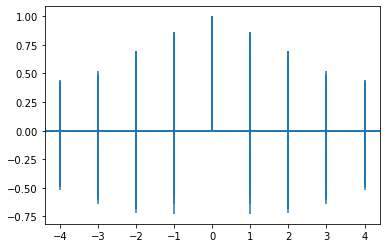

In [213]:

auto_corr_mean_risk = mean_auto_corr(risk,lag)
auto_corr_mean_amb = mean_auto_corr(amb,lag)
auto_corr_mean_time = mean_auto_corr(time,lag)
auto_corr_mean_positive = mean_auto_corr(positive,lag)
auto_corr_mean_negative = mean_auto_corr(negative,lag)
#print(auto_corr_mean_risk)


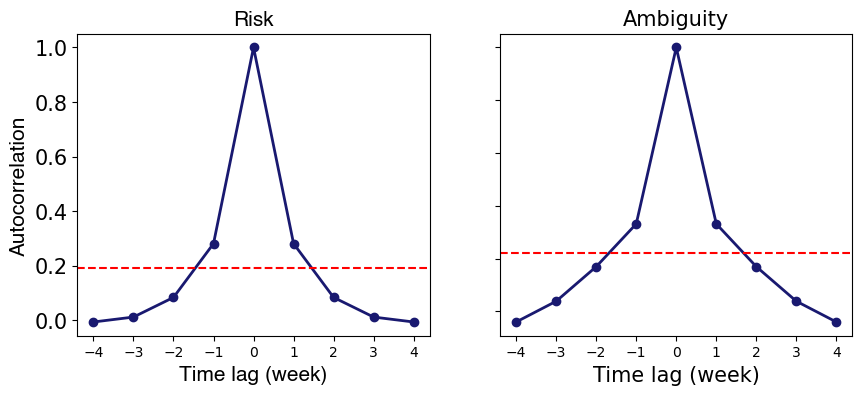

In [234]:
time_lag = [-4,-3,-2,-1,0,1,2,3,4]
correlation = [0,0.2, 0.4,0.6,0.8,1]

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.plot(time_lag,auto_corr_mean_risk,color = 'midnightblue',marker='o', linestyle='solid',linewidth=2)
plt.axhline(y=np.mean(auto_corr_mean_risk), color='r', linestyle='--')
plt.title('Risk',fontdict=font)
plt.xticks(time_lag)
plt.yticks(correlation,fontsize = 15)
plt.xlabel('Time lag (week)',fontdict=font,fontsize = 15)
plt.ylabel('Autocorrelation',fontdict=font)

plt.subplot(122)
plt.title('Ambiguity',fontsize = 15)
plt.xticks(time_lag)
plt.plot(time_lag,auto_corr_mean_amb,color = 'midnightblue',marker='o', linestyle='solid',linewidth=2)
plt.axhline(y=np.mean(auto_corr_mean_amb), color='r', linestyle='--')
plt.yticks(correlation,fontsize = 15, color = 'white')
plt.xlabel('Time lag (week)',fontsize = 15)
#plt.ylabel('autocorrelation')
plt.savefig('Figure3-autocorelation-detredn-Levy-task.png',dpi = 1000)

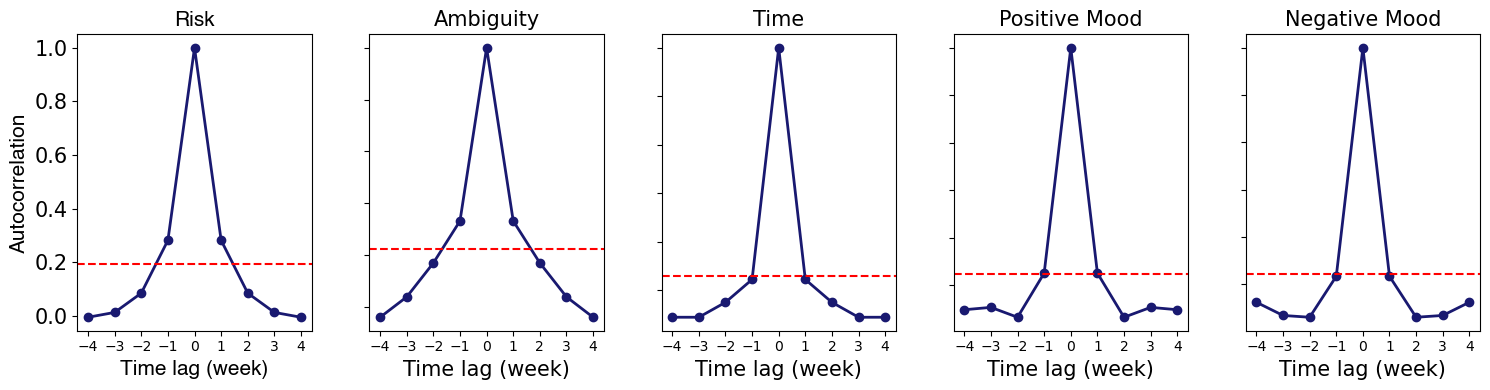

In [215]:
time_lag = [-4,-3,-2,-1,0,1,2,3,4]
plt.figure(figsize=(15, 4), dpi=100)
plt.subplot(151)
plt.plot(time_lag,auto_corr_mean_risk,color = 'midnightblue',marker='o', linestyle='solid',linewidth=2)
plt.axhline(y=np.mean(auto_corr_mean_risk), color='r', linestyle='--')
plt.title('Risk',fontdict=font)
plt.xticks(time_lag)
plt.yticks(correlation,fontsize = 15)
plt.xlabel('Time lag (week)',fontdict=font,fontsize = 15)
plt.ylabel('Autocorrelation',fontdict=font)

plt.subplot(152)
plt.title('Ambiguity',fontsize = 15)
plt.xticks(time_lag)
plt.plot(time_lag,auto_corr_mean_amb,color = 'midnightblue',marker='o', linestyle='solid',linewidth=2)
plt.axhline(y=np.mean(auto_corr_mean_amb), color='r', linestyle='--')
plt.yticks(correlation,fontsize = 15, color = 'white')
plt.xlabel('Time lag (week)',fontsize = 15)
#plt.ylabel('autocorrelation')

plt.subplot(153)
plt.title('Time',fontsize = 15)
plt.xticks(time_lag)
plt.plot(time_lag,auto_corr_mean_time,color = 'midnightblue',marker='o', linestyle='solid',linewidth=2)
plt.axhline(y=np.mean(auto_corr_mean_time), color='r', linestyle='--')
plt.yticks(correlation,fontsize = 15, color = 'white')
plt.xlabel('Time lag (week)',fontsize = 15)
#plt.ylabel('autocorrelation')
plt.tight_layout()

plt.subplot(154)
plt.title('Positive Mood',fontsize = 15)
plt.xticks(time_lag)
plt.yticks(correlation)
plt.plot(time_lag,auto_corr_mean_positive,color = 'midnightblue',marker='o', linestyle='solid',linewidth=2)
plt.axhline(y=np.mean(auto_corr_mean_positive), color='r', linestyle='--')
plt.yticks(correlation,fontsize = 15, color = 'white')
plt.xlabel('Time lag (week)',fontsize = 15)
#plt.ylabel('autocorrelation')
plt.tight_layout()

plt.subplot(155)
plt.title('Negative Mood',fontsize = 15)
plt.xticks(time_lag)
plt.plot(time_lag,auto_corr_mean_negative,color = 'midnightblue',marker='o', linestyle='solid',linewidth=2)
plt.axhline(y=np.mean(auto_corr_mean_negative), color='r', linestyle='--')
plt.yticks(correlation,fontsize = 15, color = 'white')
plt.xlabel('Time lag (week)',fontsize = 15)
#plt.ylabel('autocorrelation')
plt.tight_layout()
#plt.savefig('Figure3-autocorrelation.png',dpi=1000)
plt.savefig('Figure3-autocorelation-detredn.png',dpi = 1000)

## Autocorrelation Algorthim

T is the totoal T of the time series

k is the time point

$r_{k} = \frac{c_{k}}{c_{0}} $

$c_{k} = \frac{1}{T}\sum^{T-k}_{t=1}(y_{t}-\bar{y})(y_{t+k}-\bar{y})$

$c_{0}$ is the sample variance of the time series

formula source: https://www.mathworks.com/help/econ/autocorr.html#btzjb3t

In [281]:
#print(positive.iloc[0,1:])
data = risk
T = 16
k = 4
autocorr = np.empty([data.shape[0],2*k+1])

for s in range(data.shape[0]):
    auto_arr = np.ones(9)
    auto = []
    for i in range(k):
        x = data.iloc[s,1:][0:-(i+1)]
        x_1 = data.iloc[s,1:][(i+1):]
        xx = np.empty([T-(i+1),2])
        xx[:,0] = x
        xx[:,1] = x_1

        xxx = xx-np.mean(data.iloc[s,1:])
        var = np.var(data.iloc[s,1:])
        auto.append(np.sum(xxx[:,0]*xxx[:,1])/T/var)
    auto_arr[5:2*k+1] = auto
    auto_arr[0:k] = auto[::-1]
    autocorr[s,:] = auto_arr

array([0.2648148148148149, 0.15046296296296297, 0.22500000000000006,
       0.25879629629629636, 1.0, 0.25879629629629636, 0.22500000000000006,
       0.15046296296296297, 0.2648148148148149], dtype=object)

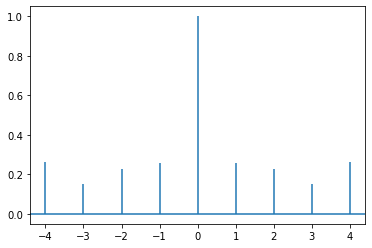

In [285]:
x = data.iloc[2,1:]
auto_corr = plt.acorr(matplotlib.mlab.detrend_mean(x), maxlags = lag)
auto_corr[1]